# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import itertools
import numpy as np
from torchsummary import summary
from torchvision import models
import torch.nn.functional as F
#import seaborn as sns
#from sklearn.metrics import confusion_matrix

# Set Device (GPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Transformations for Training and Testing

In [3]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loading CIFAR-10 Dataset

Files already downloaded and verified
Files already downloaded and verified


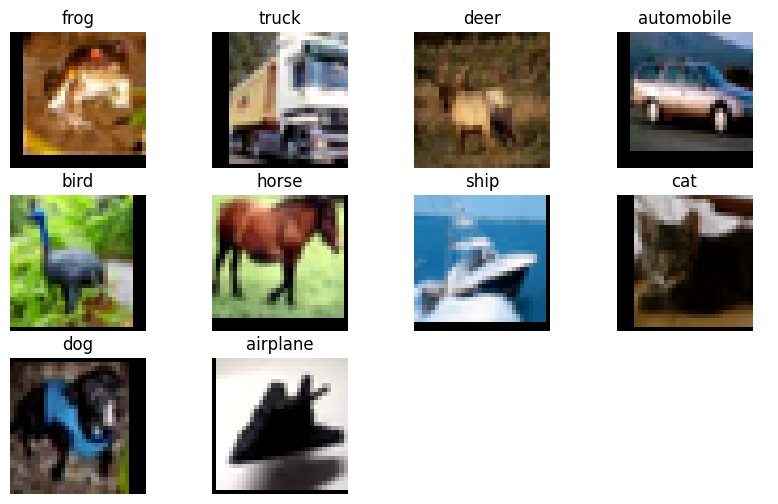

In [4]:
# Load CIFAR-10 dataset
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Display sample images 
def show_images_from_classes(dataset, classes, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    fig, axs = plt.subplots(3, 4, figsize=(10, 6)) 
    axs = axs.ravel()  
    displayed_classes = set()  
    for i in range(len(dataset)):
        img, label = dataset[i]
        if classes[label] not in displayed_classes:
            displayed_classes.add(classes[label])
            img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
            npimg = np.clip(img.numpy(), 0, 1)
            axs[len(displayed_classes)-1].imshow(np.transpose(npimg, (1, 2, 0)))
            axs[len(displayed_classes)-1].set_title(classes[label])
            axs[len(displayed_classes)-1].axis('off')
        
        if len(displayed_classes) == len(classes):
            break  
    
    # Turn off any extra subplots
    for j in range(len(displayed_classes), len(axs)):
        axs[j].axis('off')
    
    plt.show()

# Display one sample image from each class
show_images_from_classes(trainset_full, classes)

# Split Dataset into Training and Validation Sets (80-20 split)

In [5]:
# Split into Training and Validation Sets (80-20 split)
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Dataset Summary and Class Display

In [28]:
def dataset_summary():
    print("Dataset Summary:")
    print(f"Total training samples: {len(trainset_full)}")
    print(f"Training set size: {len(trainset)}")
    print(f"Validation set size: {len(valset)}")
    print(f"Test set size: {len(testset)}")
    print("Classes:", trainset_full.classes)

dataset_summary()

Dataset Summary:
Total training samples: 50000
Training set size: 40000
Validation set size: 10000
Test set size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Plot Training and Validation Accuracy Curves

In [7]:
def plot_training_and_validation_accuracy(train_acc, val_acc, model_name):
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy Curve - {model_name}")
    plt.legend()
    plt.show()

# Evaluate Model on Test Set

In [8]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Training Function with Validation

In [29]:
# Training function with validation
def train_model_with_validation(model, criterion, optimizer, num_epochs=10):
    train_acc, val_acc = [], []
    for epoch in range(num_epochs):
        # Training
        model.train()
        correct_train, total_train, running_loss = 0, 0, 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Accuracy and loss tracking
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item()

        # Calculate training accuracy
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct_train / total_train
        train_acc.append(epoch_accuracy)
        
        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        val_acc.append(val_accuracy)
        
        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")
        
    return train_acc, val_acc

# Basic CNN 

In [39]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/10], Loss: 2.1246, Train Accuracy: 23.98%, Validation Accuracy: 29.95%
Epoch [2/10], Loss: 1.8434, Train Accuracy: 34.16%, Validation Accuracy: 37.05%
Epoch [3/10], Loss: 1.6887, Train Accuracy: 39.05%, Validation Accuracy: 41.50%
Epoch [4/10], Loss: 1.5935, Train Accuracy: 42.39%, Validation Accuracy: 43.04%
Epoch [5/10], Loss: 1.5270, Train Accuracy: 45.09%, Validation Accuracy: 45.70%
Epoch [6/10], Loss: 1.4768, Train Accuracy: 46.78%, Validation Accuracy: 47.55%
Epoch [7/10], Loss: 1.4347, Train Accuracy: 48.25%, Validation Accuracy: 48.99%
Epoch [8/10], Loss: 1.3982, Train Accuracy: 49.95%, Validation Accuracy: 50.24%
Epoch [9/10], Loss: 1.3604, Train Accuracy: 51.36%, Validation Accuracy: 51.75%
Epoch [10/10], Loss: 1.3310, Train Accuracy: 52.39%, Validation Accuracy: 52.67%


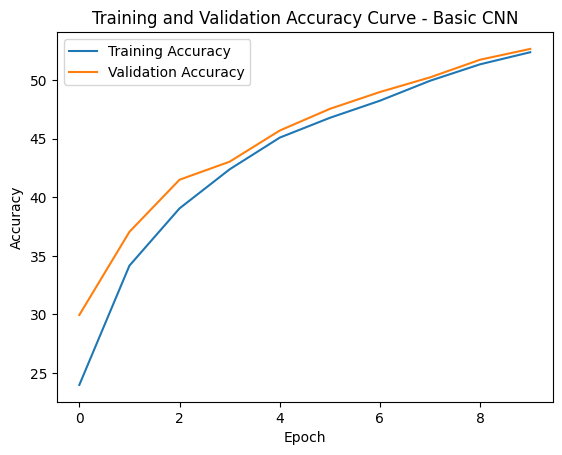

Test Accuracy: 55.45%
Test Accuracy for Basic CNN: 55.45%


In [40]:
# Instantiate the model, define the loss function and optimizer
model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model and track accuracy
train_acc, val_acc = train_model_with_validation(model, criterion, optimizer, num_epochs=10)

# Plot the training and validation accuracy
plot_training_and_validation_accuracy(train_acc, val_acc, "Basic CNN")

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, testloader)
print(f"Test Accuracy for Basic CNN: {test_accuracy:.2f}%")

# Hyperparameter Tuning for Basic CNN

In [41]:
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        
        # Convolutional Layers with Batch Normalization and Dropout
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling and Dropout Layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) 

    def forward(self, x):
        # Convolutional Layer 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Convolutional Layer 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Convolutional Layer 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten for Fully Connected Layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output Layer
        x = self.fc3(x)
        
        return x

In [42]:
# Instantiate the model, define the loss function and optimizer
model_optimized = OptimizedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_optimized.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)


E:\Codes_data\try\envs\ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Loss: 1.6762, Train Accuracy: 37.65%, Validation Accuracy: 50.49%
Epoch [2/10], Loss: 1.3045, Train Accuracy: 52.37%, Validation Accuracy: 57.79%
Epoch [3/10], Loss: 1.1461, Train Accuracy: 58.85%, Validation Accuracy: 62.52%
Epoch [4/10], Loss: 1.0446, Train Accuracy: 62.90%, Validation Accuracy: 62.61%
Epoch [5/10], Loss: 0.9651, Train Accuracy: 66.41%, Validation Accuracy: 63.07%
Epoch [6/10], Loss: 0.9112, Train Accuracy: 68.00%, Validation Accuracy: 71.30%
Epoch [7/10], Loss: 0.8651, Train Accuracy: 69.45%, Validation Accuracy: 71.00%
Epoch [8/10], Loss: 0.8311, Train Accuracy: 71.05%, Validation Accuracy: 73.83%
Epoch [9/10], Loss: 0.7943, Train Accuracy: 72.39%, Validation Accuracy: 72.42%
Epoch [10/10], Loss: 0.7704, Train Accuracy: 73.32%, Validation Accuracy: 74.12%


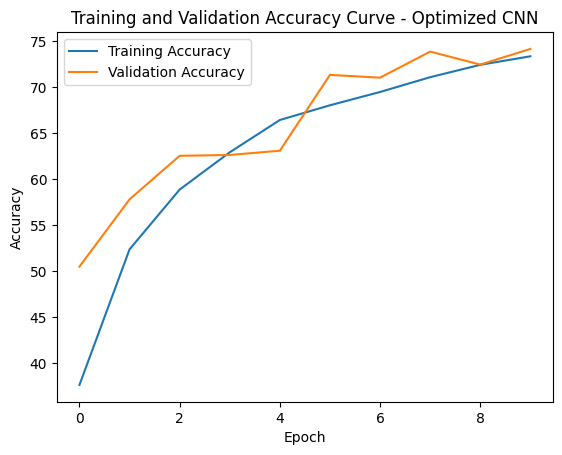

Test Accuracy: 75.94%
Test Accuracy for Optimized CNN: 75.94%


In [44]:
# Train the model and track accuracy
train_acc_optimized, val_acc_optimized = train_model_with_validation(
    model_optimized, criterion, optimizer,  num_epochs=10
)

# Plot the training and validation accuracy for the optimized model
plot_training_and_validation_accuracy(train_acc_optimized, val_acc_optimized, "Optimized CNN")

# Evaluate the optimized model on the test set
test_accuracy_optimized = evaluate_model(model_optimized, testloader)
print(f"Test Accuracy for Optimized CNN: {test_accuracy_optimized:.2f}%")

In [50]:
# Function to define and summarise ResNet-18
def resnet18_summary():
    print("\nResNet-18 Model Summary:")
    model = models.resnet18(weights=None)  
    model.fc = nn.Linear(model.fc.in_features, 10) 
    model = model.to(device)
    summary(model, (3, 32, 32))

# Function to define and summarise AlexNet
def alexnet_summary():
    print("\nAlexNet Model Summary:")
    model = models.alexnet(weights=None)
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) 
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  
    model = model.to(device)
    summary(model, (3, 32, 32))

# Function to define and summarise MobileNetV2
def mobilenet_v2_summary():
    print("\nMobileNetV2 Model Summary:")
    model = models.mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10) 
    model = model.to(device)
    summary(model, (3, 32, 32))

# Define ResNet-18 & MobileNetV2 Model

In [31]:
def get_resnet18():
    model = torchvision.models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, 10)  

    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout with 50% probability
        nn.Linear(num_features, 10)  
    )
    
    return model.to(device)
    

def get_mobilenet_v2():
    model = torchvision.models.mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    return model.to(device)

In [45]:
# Display resnet18 model summaries
resnet18_summary()


ResNet-18 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             

# Baseline Training for ResNet-18

Training ResNet-18 Baseline...
Epoch [1/10], Loss: 2.0058, Train Accuracy: 27.62%, Validation Accuracy: 38.71%
Epoch [2/10], Loss: 1.6376, Train Accuracy: 39.27%, Validation Accuracy: 43.98%
Epoch [3/10], Loss: 1.5117, Train Accuracy: 44.18%, Validation Accuracy: 46.63%
Epoch [4/10], Loss: 1.4286, Train Accuracy: 47.62%, Validation Accuracy: 50.05%
Epoch [5/10], Loss: 1.3560, Train Accuracy: 50.60%, Validation Accuracy: 52.27%
Epoch [6/10], Loss: 1.3019, Train Accuracy: 52.69%, Validation Accuracy: 55.09%
Epoch [7/10], Loss: 1.2435, Train Accuracy: 55.14%, Validation Accuracy: 56.06%
Epoch [8/10], Loss: 1.2073, Train Accuracy: 56.63%, Validation Accuracy: 58.05%
Epoch [9/10], Loss: 1.1672, Train Accuracy: 57.99%, Validation Accuracy: 58.34%
Epoch [10/10], Loss: 1.1338, Train Accuracy: 59.37%, Validation Accuracy: 59.44%


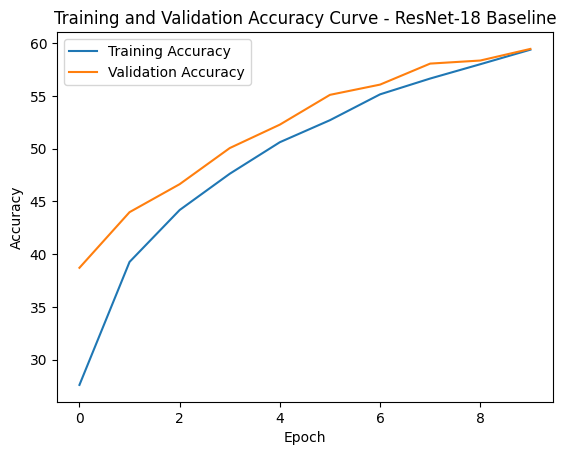

Evaluating ResNet-18 Baseline Model on Test Set...
Test Accuracy: 61.84%


61.84

In [32]:
# Baseline Training for ResNet-18 
print("Training ResNet-18 Baseline...")
resnet18_baseline = get_resnet18()
criterion = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.SGD(resnet18_baseline.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4) #  lr=0.001, momentum=0.9, weight_decay=5e-4
train_acc_resnet18, val_acc_resnet18 = train_model_with_validation(resnet18_baseline, criterion, optimizer_resnet18, num_epochs=10)  # 10 epochs 
plot_training_and_validation_accuracy(train_acc_resnet18, val_acc_resnet18, "ResNet-18 Baseline")
print("Evaluating ResNet-18 Baseline Model on Test Set...")
evaluate_model(resnet18_baseline, testloader)

# Baseline Training for MobileNetV2


Training MobileNetV2 Baseline...
Epoch [1/10], Loss: 2.2174, Train Accuracy: 15.89%, Validation Accuracy: 21.15%
Epoch [2/10], Loss: 1.9694, Train Accuracy: 24.87%, Validation Accuracy: 29.33%
Epoch [3/10], Loss: 1.8321, Train Accuracy: 31.12%, Validation Accuracy: 33.32%
Epoch [4/10], Loss: 1.7515, Train Accuracy: 34.29%, Validation Accuracy: 36.15%
Epoch [5/10], Loss: 1.6960, Train Accuracy: 36.70%, Validation Accuracy: 38.07%
Epoch [6/10], Loss: 1.6461, Train Accuracy: 38.77%, Validation Accuracy: 39.36%
Epoch [7/10], Loss: 1.6018, Train Accuracy: 40.38%, Validation Accuracy: 42.00%
Epoch [8/10], Loss: 1.5622, Train Accuracy: 42.24%, Validation Accuracy: 43.23%
Epoch [9/10], Loss: 1.5325, Train Accuracy: 43.09%, Validation Accuracy: 43.83%
Epoch [10/10], Loss: 1.5072, Train Accuracy: 44.47%, Validation Accuracy: 45.15%


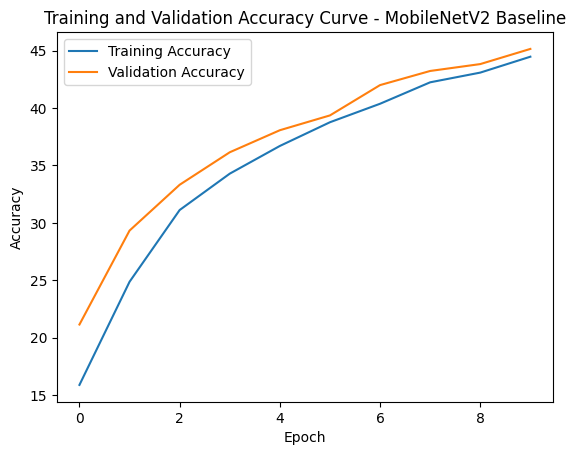

Evaluating MobileNetV2 Baseline Model on Test Set...
Test Accuracy: 46.82%


46.82

In [33]:
print("\nTraining MobileNetV2 Baseline...")
mobilenet_v2_baseline = get_mobilenet_v2()
optimizer_mobilenet_v2 = optim.SGD(mobilenet_v2_baseline.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
train_acc_mobilenet_v2, val_acc_mobilenet_v2 = train_model_with_validation(mobilenet_v2_baseline, criterion, optimizer_mobilenet_v2, num_epochs=10)
plot_training_and_validation_accuracy(train_acc_mobilenet_v2, val_acc_mobilenet_v2, "MobileNetV2 Baseline")
print("Evaluating MobileNetV2 Baseline Model on Test Set...")
evaluate_model(mobilenet_v2_baseline, testloader)

In [46]:
# Model's summary
mobilenet_v2_summary()


MobileNetV2 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      Batch

# Hyperparameter Tuning for ResNet-18

In [34]:
# Hyperparameters taken 
learning_rate = 0.01
weight_decay = 0.0001
optimizer_type = 'Adam'

# Function to set optimiser with updated hyperparameters
def get_optimizer(model):
    return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# Improved training function for ResNet-18 with dropout
def improved_training(model_fn, model_name, num_epochs=10):
    print(f"\nTraining {model_name} with adjusted configuration: lr={learning_rate}, optimizer={optimizer_type}, weight_decay={weight_decay}") 
    model = model_fn()  # Use the modified ResNet-18 with dropout
    optimizer = get_optimizer(model)
    criterion = nn.CrossEntropyLoss()
    train_acc, val_acc = train_model_with_validation(model, criterion, optimizer, num_epochs=num_epochs)  
    test_accuracy = evaluate_model(model, testloader) 
    plot_training_and_validation_accuracy(train_acc, val_acc, f"{model_name}")  # Plot training and validation accuracy for the adjusted configuration
    print(f"Test Accuracy for {model_name}: {test_accuracy:.2f}%")

Optimisation for ResNet-18 

Training ResNet-18 with adjusted configuration: lr=0.01, optimizer=Adam, weight_decay=0.0005
Epoch [1/10], Loss: 1.8988, Train Accuracy: 33.11%, Validation Accuracy: 41.29%
Epoch [2/10], Loss: 1.5775, Train Accuracy: 44.43%, Validation Accuracy: 47.33%
Epoch [3/10], Loss: 1.4215, Train Accuracy: 50.75%, Validation Accuracy: 51.05%
Epoch [4/10], Loss: 1.2880, Train Accuracy: 55.18%, Validation Accuracy: 55.65%
Epoch [5/10], Loss: 1.1726, Train Accuracy: 59.22%, Validation Accuracy: 59.62%
Epoch [6/10], Loss: 1.0730, Train Accuracy: 62.56%, Validation Accuracy: 61.03%
Epoch [7/10], Loss: 1.0177, Train Accuracy: 64.54%, Validation Accuracy: 62.81%
Epoch [8/10], Loss: 0.9590, Train Accuracy: 66.63%, Validation Accuracy: 65.42%
Epoch [9/10], Loss: 0.9172, Train Accuracy: 67.64%, Validation Accuracy: 66.12%
Epoch [10/10], Loss: 0.8687, Train Accuracy: 69.64%, Validation Accuracy: 68.70%
Test Accuracy: 69.71%


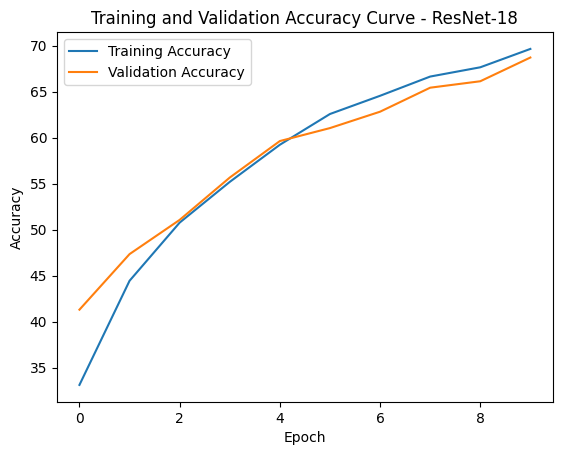

Test Accuracy for ResNet-18: 69.71%


In [36]:
print("Optimisation for ResNet-18 ")
improved_training(get_resnet18, "ResNet-18")

# # Hyperparameter Tuning for MobileNetV2

In [37]:
# Hyperparameters chosen for MobileNetV2
learning_rate = 0.01
weight_decay =  0.0005
optimizer_type = 'Adam'

# Improved training function for MobileNetV2
def improved_training_for_MobileNetV2(model_fn, model_name, num_epochs=10):
    print(f"\nTraining {model_name} with Hyperparameters chosen: lr={learning_rate}, optimizer={optimizer_type}, weight_decay={weight_decay}")  
    model = model_fn()
    optimizer = get_optimizer(model)  
    criterion = nn.CrossEntropyLoss()
    train_acc, val_acc = train_model_with_validation(model, criterion, optimizer, num_epochs=num_epochs)    
    test_accuracy = evaluate_model(model, testloader)   
    plot_training_and_validation_accuracy(train_acc, val_acc, f"{model_name} (Adjusted)")  # Plotting training and validation accuracy for the adjusted configuration
    print(f"Test Accuracy for {model_name}: {test_accuracy:.2f}%")


 Optimisation for MobileNetV2

Training MobileNetV2 with Hyperparameters chosen: lr=0.01, optimizer=Adam, weight_decay=0.0005
Epoch [1/10], Loss: 2.1105, Train Accuracy: 23.05%, Validation Accuracy: 29.43%
Epoch [2/10], Loss: 1.7821, Train Accuracy: 34.42%, Validation Accuracy: 38.31%
Epoch [3/10], Loss: 1.6389, Train Accuracy: 39.89%, Validation Accuracy: 43.57%
Epoch [4/10], Loss: 1.5379, Train Accuracy: 44.20%, Validation Accuracy: 45.73%
Epoch [5/10], Loss: 1.4644, Train Accuracy: 47.15%, Validation Accuracy: 44.17%
Epoch [6/10], Loss: 1.4023, Train Accuracy: 49.05%, Validation Accuracy: 49.78%
Epoch [7/10], Loss: 1.3377, Train Accuracy: 51.70%, Validation Accuracy: 51.77%
Epoch [8/10], Loss: 1.2863, Train Accuracy: 53.87%, Validation Accuracy: 55.05%
Epoch [9/10], Loss: 1.2491, Train Accuracy: 55.12%, Validation Accuracy: 54.91%
Epoch [10/10], Loss: 1.1934, Train Accuracy: 57.34%, Validation Accuracy: 57.78%
Test Accuracy: 60.23%


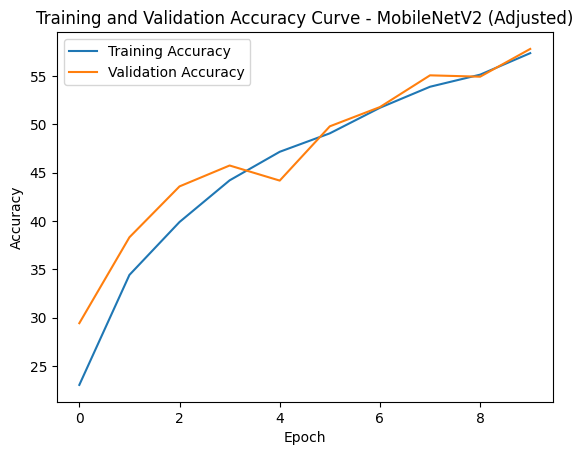

Test Accuracy for MobileNetV2: 60.23%


In [38]:
print("\n Optimisation for MobileNetV2")
improved_training_for_MobileNetV2(get_mobilenet_v2, "MobileNetV2")

In [47]:
# Model's summary
alexnet_summary()


AlexNet Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         307,392
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool

# Define AlexNet

In [24]:
# Define the AlexNet model and move to the device
def get_alexnet():
    model = models.alexnet(pretrained=False)
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # 10 classes for CIFAR-10
    return model.to(device)

# Training function with accuracy tracking
def train_model_with_accuracy_tracking(model, criterion, optimizer, trainloader, valloader, num_epochs=10):
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        correct_train, total_train = 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Track accuracy
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        train_acc.append(train_accuracy)
        
        # Validation phase
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_acc.append(val_accuracy)

        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    return train_acc, val_acc

# Baseline Training for AlexNet

Epoch [1/10], Train Accuracy: 10.78%, Validation Accuracy: 9.50%
Epoch [2/10], Train Accuracy: 10.92%, Validation Accuracy: 13.33%
Epoch [3/10], Train Accuracy: 16.89%, Validation Accuracy: 22.52%
Epoch [4/10], Train Accuracy: 23.56%, Validation Accuracy: 24.63%
Epoch [5/10], Train Accuracy: 26.63%, Validation Accuracy: 28.38%
Epoch [6/10], Train Accuracy: 30.83%, Validation Accuracy: 34.93%
Epoch [7/10], Train Accuracy: 34.81%, Validation Accuracy: 35.22%
Epoch [8/10], Train Accuracy: 37.87%, Validation Accuracy: 39.96%
Epoch [9/10], Train Accuracy: 41.26%, Validation Accuracy: 44.18%
Epoch [10/10], Train Accuracy: 44.31%, Validation Accuracy: 46.80%


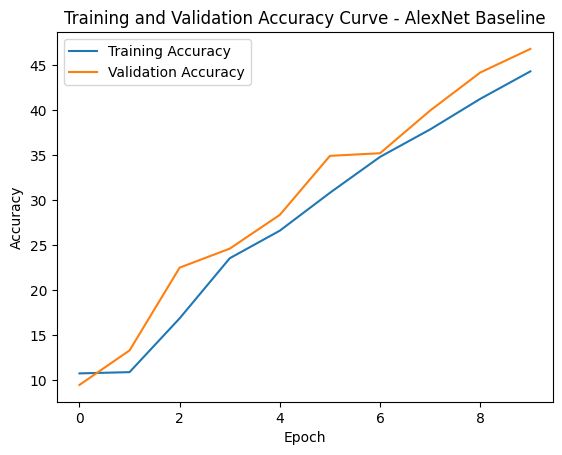

Evaluating AlexNet Baseline Model on Test Set...
Test Accuracy: 48.54%


48.54

In [25]:
# Load model, criterion, and optimizer
model = get_alexnet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Assuming trainloader, valloader, and testloader are defined
# Train the model
train_acc, val_acc = train_model_with_accuracy_tracking(model, criterion, optimizer, trainloader, valloader, num_epochs=10)

# Plot training and validation accuracy
plot_training_and_validation_accuracy(train_acc, val_acc, "AlexNet Baseline")

# Evaluate model on the test set
print("Evaluating AlexNet Baseline Model on Test Set...")
evaluate_model(model, testloader)

# Hyperparameter Tuning for AlexNet


Hyperparameter Tuning: lr=0.01, weight_decay=0.0005
Epoch [1/10], Train Accuracy: 18.94%, Validation Accuracy: 27.75%
Epoch [2/10], Train Accuracy: 35.12%, Validation Accuracy: 42.53%
Epoch [3/10], Train Accuracy: 46.94%, Validation Accuracy: 49.29%
Epoch [4/10], Train Accuracy: 55.76%, Validation Accuracy: 58.77%
Epoch [5/10], Train Accuracy: 62.10%, Validation Accuracy: 63.97%
Epoch [6/10], Train Accuracy: 66.19%, Validation Accuracy: 67.93%
Epoch [7/10], Train Accuracy: 69.78%, Validation Accuracy: 69.23%
Epoch [8/10], Train Accuracy: 72.31%, Validation Accuracy: 71.42%
Epoch [9/10], Train Accuracy: 75.21%, Validation Accuracy: 72.86%
Epoch [10/10], Train Accuracy: 77.26%, Validation Accuracy: 75.91%


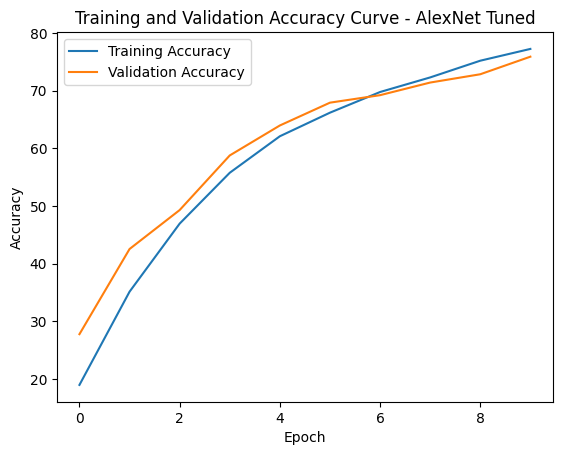

Evaluating AlexNet Tuned Model on Test Set...
Test Accuracy: 77.66%


77.66

In [27]:
# Hyperparameter tuning with different learning rate and weight decay
print("\nHyperparameter Tuning: lr=0.01, weight_decay=0.0005")
model_tuned = get_alexnet()  # Instantiate a fresh model
optimizer_tuned = optim.SGD(model_tuned.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Train the model with tuned hyperparameters
train_acc_tuned, val_acc_tuned = train_model_with_accuracy_tracking(model_tuned, criterion, optimizer_tuned, trainloader, valloader, num_epochs=10)

# Plot training and validation accuracy for tuned model
plot_training_and_validation_accuracy(train_acc_tuned, val_acc_tuned, "AlexNet Tuned")

# Evaluate tuned model on the test set
print("Evaluating AlexNet Tuned Model on Test Set...")
evaluate_model(model_tuned, testloader)

In [49]:
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=True))
